In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [2]:
# @title Loading optuna
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.3 MB/s eta 0:00:00


Data shape: (1048575,)


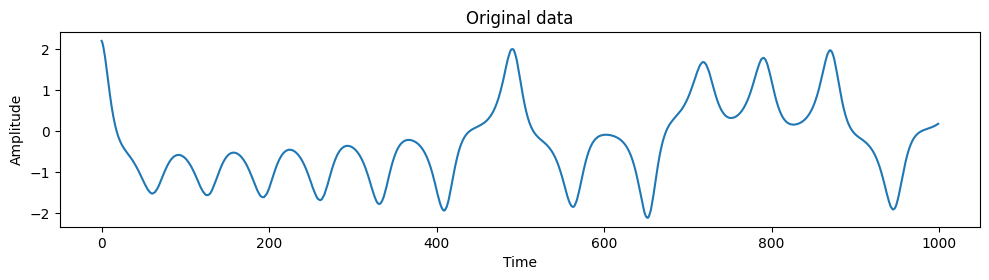

In [3]:
# @title Data reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


# find missing values
nan_indices = np.where(np.isnan(data))

# delete missing values
data = np.delete(data, nan_indices)

# average and standard deviation
mean_value = np.mean(data)
std_dev = np.std(data)

# Standardization
data = (data - mean_value) / std_dev


print('Data shape:',data.shape)

#######
# Visualization

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

In [4]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W



#############################
# reservoir state vector
#############################

def Reservoir(x_in,x,W,alpha,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x = (1.0 - alpha) * x \
                 + alpha * np.tanh(np.dot(W, x)+Wbias \
                 + x_in)
        return x

############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):

    x = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))

    for n in range(T_train):

            # reservoir state vector
        x = Reservoir(np.dot(Win,train_U[n,:]),x,W,alpha,bias_scale)

            # teacher data
        d = train_D[n,:]


        if n > discard_len:  # discard the first part of the data
            X_XT, D_XT = Ridge(d, x, X_XT, D_XT)

    return X_XT, D_XT,x


########################
#induction formula for creating estimated data
########################

def run(test_U,x,Win,W,Wout,alpha,T_test,bias_scale):


    Y_pred = []
    y = test_U[0,:]


    for n in range(T_test):

        x = Reservoir(np.dot(Win,y),x,W,alpha,bias_scale)
        y_pred = np.dot(Wout, x)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):
    mae = mean_absolute_error(data1_in, data2_in)
    return mae

In [5]:
# @title Hyperparameter: Bayesian optimization for Reservoir

n_trials    = 20   # Number of times to test with optuna (generate MAE for this number of times)

T_train     = 1500 # Training period
T_test      = 100  # Forecast period
test_num    = 50   # Number of times for one test (to get one MAE)
discard_len = 10   # Number of steps not learned at the beginning (not important)

Node        = 150  # Reservoir Node

In [6]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))

################
#We can load (in csv file) and reuse the past trials

file_path = 'reservoir.csv'
past_trials = []
if os.path.exists(file_path):


# Import data from CSV files

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:
        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'lag': int(row['lag']),
                   'dim': int(row['dim']),
                   'N_x': int(row['N_x']),
                   'beta': float(row['beta']),
                   'density': float(row['density']),
                   'input_scale': float(row['input_scale']),
                   'rho': float(row['rho']),
                   'alpha': float(row['alpha']),
                   'seed_value': float(row['seed_value']),
                   'bias_scale': float(row['bias_scale'])
               }
           }
           past_trials.append(trial_data)




# Creating an Optuna Study
study = optuna.create_study(direction="minimize")

############################
# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL

    trial_id = len(study.trials)

    frozen_trial = FrozenTrial(
      number=trial_id,  # trial number
      state=TrialState.COMPLETE,
      value=trial['value'],
      datetime_start=datetime.now(),
      datetime_complete=datetime.now(),
      params=trial['params'],
      distributions={
          'lag': optuna.distributions.IntUniformDistribution(3, 10),
          'dim': optuna.distributions.IntUniformDistribution(3, 15),
          'N_x': optuna.distributions.IntUniformDistribution(Node, Node),
          'beta': optuna.distributions.FloatDistribution(0.0001, 0.0001),
          'density': optuna.distributions.FloatDistribution(0.001, 1),
          'input_scale': optuna.distributions.FloatDistribution(0, 1.5),
          'rho': optuna.distributions.FloatDistribution(0, 1.5),
          'alpha': optuna.distributions.FloatDistribution(0, 1),
          'seed_value': optuna.distributions.FloatDistribution(0, 100),
          'bias_scale': optuna.distributions.FloatDistribution(-1.5, 1.5)
      },
      user_attrs={},
      system_attrs={},
      intermediate_values={},
      trial_id=trial_id
    )
    study.add_trial(frozen_trial)
#################################

# Objective Function Definition
def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 3, 15)
    N_x = trial.suggest_int("N_x", Node, Node)                #Initially fixed here
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density = trial.suggest_float("density", 0.001, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho = trial.suggest_float("rho", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1.5, 1.5)

###############

    T_0 = T_train + lag * dim
###############
#Initialization of estimated data

    data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)
    test_Y = np.zeros((T_test,test_num))
    test_D = np.zeros((T_test,test_num))
    tentative_test_Y=np.zeros((T_test,dim,test_num))
    data_delay_train = np.zeros((T_train+1,dim,test_num), dtype=float)

###############
#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)



###############
#Convert data to a delay coordinate system

    for t in range(test_num):
        for i in range(dim):

            data_delay_train[:,i,t] = data[T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag Step-delayed time series


# Initialization of training data

        train_U = np.zeros((T_train,dim), dtype=float)
        train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

        train_U = data_delay_train[:T_train,:,t]
        train_D = data_delay_train[1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        X_XT, D_XT,x_special = train(train_U,train_D,np.zeros(N_x),T_train, \
                                     Win, W, N_x, dim, alpha,discard_len,bias_scale)

 # Generate regression weight matrix

        Wout= None
        Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############

#Convert test data to a delay coordinate system

        for i in range(dim):

            data_delay[:,i,t] = data[T_0+t-T_train-i*lag:
                                            T_0+t+T_test-i*lag+1] # i*lag step delayed time series


  #Generate estimated data


        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_special, \
                                      Win,W,Wout,alpha,T_test,bias_scale)
        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1:T_train+T_test+1,0,t]


#Preparation for calculating MAE

    test_Y_cor = [0]*test_num
    data_delay_cor = [0]*test_num

    for t in range(test_num):

        test_Y_cor[t] = test_Y[T_test-1,t]
        data_delay_cor[t] = test_D[T_test-1,t]


# Calculate autocorrelation

    return MAE(test_Y_cor[:],data_delay_cor[:])

#############


# Perform optimization
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

#######
#######

# Write to CSV file

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'reservoir.csv')



# Write additional CSV files with the latest trial data

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

# Writing header lines (first time only)
    if file.tell() == 0:
        writer.writerow(['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value', 'bias_scale'])

    # Write all trials
    for trial in study.trials:
        lag_value = trial.params.get('lag')
        if lag_value is not None:  # Write only if lag is not None
           writer.writerow([
    #trial.number,
    trial.value,
    trial.params.get('lag', None),
    trial.params.get('dim', None),
    trial.params.get('N_x', None),
    trial.params.get('beta', None),
    trial.params.get('density', None),
    trial.params.get('input_scale', None),
    trial.params.get('rho', None),
    trial.params.get('alpha', None),
    trial.params.get('seed_value', None),
    trial.params.get('bias_scale', None)
])



[I 2025-08-25 01:33:29,266] A new study created in memory with name: no-name-d13a9262-5af2-468f-8fd8-d4ee524bb257


1048575


[I 2025-08-25 01:33:37,498] Trial 0 finished with value: 0.15417652628524817 and parameters: {'lag': 6, 'dim': 11, 'N_x': 150, 'beta': 0.0001, 'density': 0.12004152459343577, 'input_scale': 0.40462111020629876, 'rho': 1.3892789169647117, 'alpha': 0.3689531107794639, 'seed_value': 52.74252588266326, 'bias_scale': -0.23786353846275765}. Best is trial 0 with value: 0.15417652628524817.
[I 2025-08-25 01:33:46,486] Trial 1 finished with value: 1.9082569929359212 and parameters: {'lag': 4, 'dim': 3, 'N_x': 150, 'beta': 0.0001, 'density': 0.436729599128442, 'input_scale': 0.8217705271714321, 'rho': 1.3093456626105981, 'alpha': 0.8326406071334667, 'seed_value': 15.485170535010685, 'bias_scale': -0.08558577059249362}. Best is trial 0 with value: 0.15417652628524817.
[I 2025-08-25 01:33:50,417] Trial 2 finished with value: 0.15616273079913726 and parameters: {'lag': 6, 'dim': 10, 'N_x': 150, 'beta': 0.0001, 'density': 0.8150007468684243, 'input_scale': 0.18932322462789697, 'rho': 1.0040053853095

Best trial:
  'params': {'lag': 5, 'dim': 14, 'N_x': 150, 'beta': 0.0001, 'density': 0.7830759987243465, 'input_scale': 0.6506642476794777, 'rho': 0.8446275631354321, 'alpha': 0.290931495096631, 'seed_value': 1.4426293382749487, 'bias_scale': -0.8196458417401254},
  'value': 0.0694659479115903,
CPU times: user 1min 28s, sys: 52.8 ms, total: 1min 28s
Wall time: 1min 33s


In [7]:

#ベストなパラメタを取得する場合
best_params = study.best_params  # ベストなパラメータを取得

lag          = best_params["lag"]
dim          = best_params["dim"]
N_x          = best_params["N_x"]
beta         = best_params["beta"]
density      = best_params["density"]
input_scale  = best_params["input_scale"]
rho          = best_params["rho"]
alpha        = best_params["alpha"]
seed_value   = best_params["seed_value"]
bias_scale   = best_params["bias_scale"]

# 出力して確認
print(f"lag= {lag}")
print(f"dim= {dim}")
print(f"N_x= {N_x}")
print(f"beta= {beta}")
print(f"density= {density}")
print(f"input_scale= {input_scale}")
print(f"rho= {rho}")
print(f"alpha= {alpha}")
print(f"seed_value= {seed_value}")
print(f"bias_scale= {bias_scale}")


lag= 5
dim= 14
N_x= 150
beta= 0.0001
density= 0.7830759987243465
input_scale= 0.6506642476794777
rho= 0.8446275631354321
alpha= 0.290931495096631
seed_value= 1.4426293382749487
bias_scale= -0.8196458417401254


In [8]:
test_num    = 300               # Estimated number of times for a single test (calculate one PCC)
                                # We regard real data as a non-autonomous system, so not to predict too far into the future

T_slide     = T_test+test_num   # The test start time is shifted by making it like T_test+test_num
                                # We do not want to make predictions too far into the future

MAE: 0.023209226976254646
forecast period: 100


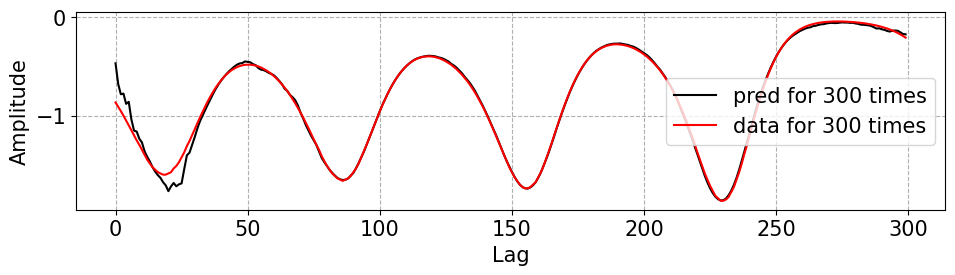

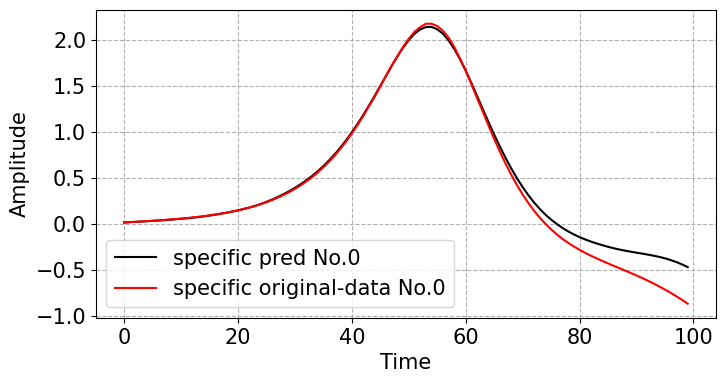

CPU times: user 25.4 s, sys: 44.7 ms, total: 25.4 s
Wall time: 25.4 s


In [9]:
# @title Implementation of Model Evaluation

%%time

###############################
#The test start time

T_0 = T_train+lag*dim+T_slide
###############################
#Generate Win and W again

Win= input_matrix(N_x,seed_value,input_scale,dim)
W = recurrent_matrix(N_x, density, rho,seed_value)

data_delay_train = np.zeros((T_train+1,dim,test_num), dtype=float)
data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)
test_Y = np.zeros((T_test,test_num))
test_D = np.zeros((T_test,test_num))
tentative_test_Y=np.zeros((T_test,dim,test_num))

###############################################
#Convert test data to a delay coordinate system
for t in range(test_num):

    for i in range(dim):

          data_delay_train[:,i,t] = data[T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series


# Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:T_train,:,t]
    train_D = data_delay_train[1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)

    X_XT, D_XT,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

#Generate output weight matrix
    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)


#####################################################
#Convert predictive data to a delay coordinate system

    for i in range(dim):

           data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                        :T_0+t+T_test-i*lag+1] # i*lag step delayed time series



  #Predictive data generation

    tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_special,Win,W,Wout,alpha,T_test,bias_scale)
    test_Y[:,t] = tentative_test_Y[:,0,t]
    test_D[:,t] = data_delay[T_train+1
                             :T_train+T_test+1,0,t]


############################################
#Preparation for calculating MAE

test_Y_cor = [0]*test_num
data_delay_cor = [0]*test_num



for t in range(test_num):

    test_Y_cor[t] = test_Y[T_test-1,t]
    data_delay_cor[t] = test_D[T_test-1,t]


# Calculate MAE
mae = MAE(test_Y_cor[:],data_delay_cor[:])


######################
######################

print("MAE:", mae)
print("forecast period:", T_test)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y_cor[:], color="black", label=f"pred for {test_num} times")
plt.plot(data_delay_cor[:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

#####################
T_fix = 0
#####################

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()